In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
import heartpy as hp
import os
import pickle
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['accuracy'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_accuracy'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/GRU/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/GRU/{filename}.png', bbox_inches='tight')
    plt.show()
    
"""
Pre-processing method
"""

def preprocessing1(PPG_data):
    """
    Fast Emotion Recognition reference
    """

    index = 0
    x = list(range(0,len(PPG_data[0])))
    
    for PPG in PPG_data:
        poly = np.polyfit(x, PPG, deg=50)
        polied = np.polyval(poly, x)
        detrended = PPG - polied
        PPG_data[index] = detrended
        index += 1
        
    return PPG_data


def preprocessing2(ppg_data, view = False, participant = ''):
    """
    Analysis PPG signal reference
    """
    
    # moving average function
    m_avg = lambda t, x, w : (np.asarray([t[i] for i in range(w, len(x) - w)]),
                          np.convolve(x, np.ones((2*w + 1, )) / (2*w + 1),
                                      mode = 'valid'))

    fs = len(ppg_data)/(60)  # sample rate

    # moving average
    w_size = int(fs*.5)  # width of moving window
    times = list(range(0,len(ppg_data)))
    mt, ms = m_avg(times, ppg_data, w_size)

    sign = (ppg_data[w_size:-w_size]-ms)

    analytical_signal = np.abs(signal.hilbert(sign))

    fs = len(sign) / (max(mt) - min(mt))
    w_size = int(fs)
    mt_new, mov_avg = m_avg(mt, analytical_signal, w_size)

    signal_pure = sign[w_size : -w_size] / mov_avg
    
    if view:
        plt.ioff()
        
        fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
        ax1.plot(times, ppg_data, "b-", label="Original")
        ax1.legend(loc='best')
        ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

        ax2.plot(mt, sign, 'r-', label="Pure signal")
        ax2.plot(mt_new, mov_avg, 'b-', label='Modulation', alpha=.5)
        ax2.legend(loc='best')
        ax2.set_title("Raw -> filtered", fontsize=14)#, fontweight="bold")

        ax3.plot(mt_new, signal_pure, "g-", label="Demodulated")
        ax3.set_xlim(0, mt[-1])
        ax3.set_title("Raw -> filtered -> demodulated", fontsize=14)#, fontweight="bold")

        ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
        ax3.legend(loc='best')

        fig.tight_layout()
        plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')
        
    return signal_pure

    
def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
    result = []
    peaks = []
    
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
for i in range(22):
    dir_list.append(dir_list_[i])
    
#### pop unavailable data
dir_list.pop(5)
dir_list.pop(2)

print(dir_list)
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])
Valence_data = []
Arousal_data = []
PPG_data = []
dir_list = dir_list[:1]

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
        PPG_data.append(dataP)
        Valence_data.append(Valence)
        Arousal_data.append(Arousal)
    file_num += 1
    
PPG_shape = np.array(PPG_data)
PPG_shape.shape

['s01.dat', 's02.dat', 's04.dat', 's05.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat']


(40, 7680)

In [4]:
# Concatenate PPG data of each person to use min-max normalization method 
def normalizing(preprocessed, scale=False):
    i = 1
    new_PPG = []
    tmp_PPG = np.empty(0)
    for PPG in preprocessed:
        if i % 40 != 0:
            tmp_PPG = np.concatenate([tmp_PPG, PPG])
        else:
            tmp_PPG = np.concatenate([tmp_PPG, PPG])
            new_PPG.append(tmp_PPG)
            tmp_PPG = np.empty(0)
        i += 1


    # Normalize personal PPG data and Split into per video
    new_PPG = np.array(new_PPG)
    new_PPG.shape[0]
    new_PPG = new_PPG.reshape(new_PPG.shape[0],new_PPG.shape[1],1)

    normalized = []
    
    if scale==True:
        for PPG in new_PPG:
            # Normalized personal PPG
            scaler = MinMaxScaler()
            norm = scaler.fit_transform(PPG) * 1000

            # Split into per video
            for i in range(40):
                norm_video = norm[i*7680 : i*7680+7680]
                normalized.append(norm_video)
    else:
        for PPG in new_PPG:
            # Normalized personal PPG
            scaler = MinMaxScaler()
            norm = scaler.fit_transform(PPG)

            # Split into per video
            for i in range(40):
                norm_video = norm[i*7680 : i*7680+7680]
                normalized.append(norm_video)
                

    normalized = np.array(normalized)
    print(normalized.shape)
    
    return normalized


def segmentate(normalized, Arousal_data, Valence_data, timestep=1280, stride=128):
    segmented = []
    valence_data = []
    arousal_data = []

    idx = 0
    for PPG in normalized:
        for index in range(0, len(PPG) - timestep, stride):
            segmented.append(PPG[index : index + timestep,:])
            #############
            valence_data.append(Valence_data[idx])
            arousal_data.append(Arousal_data[idx])
        idx += 1
    print(len(segmented))
    
    return segmented, valence_data, arousal_data

In [5]:
print("Valence label 0 : ",Valence_data.count(0))
print("Valence label 1 : ",Valence_data.count(1))

print("Arousal label 0 : ",Arousal_data.count(0))
print("Arousal label 1 : ",Arousal_data.count(1))

Valence label 0 :  21
Valence label 1 :  19
Arousal label 0 :  16
Arousal label 1 :  24


## Preprocessing method 1, 2

In [6]:
PPG_data = df_PPG['ppg']

preprocessed1 = preprocessing1(PPG_data)

/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [7]:
preprocessed2 = []

for PPG in PPG_data:
    preprocessed_d = preprocessing2(PPG,view=False)
    preprocessed2.append(preprocessed_d)

preprocessed2 = np.array(preprocessed2)

## Normalization * 1000 or not

In [8]:
normalized1 = normalizing(preprocessed1, scale=True)
normalized2 = normalizing(preprocessed1, scale=False)
normalized3 = normalizing(preprocessed2, scale=True)
normalized4 = normalizing(preprocessed2, scale=False)

(40, 7680, 1)
(40, 7680, 1)
(40,)
(40,)


<ipython-input-4-0e285f3dd935>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  normalized = np.array(normalized)
<ipython-input-4-0e285f3dd935>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  normalized = np.array(normalized)


## segmentation

In [9]:
timestep = 1280
stride = 2
# normalized1 = [normalized1[0]]
# normalized2 = [normalized2[0]]
# normalized3 = [normalized3[0]]
# normalized4 = [normalized4[0]]
segmented1, valence_data, arousal_data = segmentate(normalized1, Arousal_data, Valence_data,timestep=timestep,stride=stride) # preprocessing 1 with scale
segmented2, valence_data, arousal_data = segmentate(normalized2, Arousal_data, Valence_data,timestep=timestep,stride=stride) # preprocessing 1 without scale
segmented3, valence_data, arousal_data = segmentate(normalized3, Arousal_data, Valence_data,timestep=timestep,stride=stride) # preprocessing 2 with scale
segmented4, valence_data, arousal_data = segmentate(normalized4, Arousal_data, Valence_data,timestep=timestep,stride=stride) # preprocessing 2 without scale

128000
128000
125400
125400


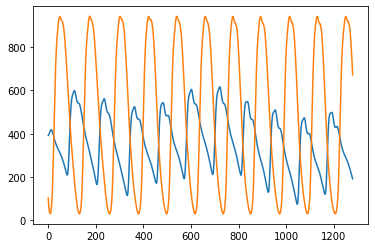

In [10]:
times = list(range(0,len(segmented1[0])))
plt.plot(times,segmented1[0])
plt.plot(times,segmented3[0])

In [11]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, GRU

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [13]:
def setTraindata(segmented, valence_data, arousal_data, type='valence'):
    if type == 'valence':
        train_x = segmented
        train_valence = valence_data
        train_arousal = arousal_data

        x_train_data = np.array(train_x).astype(np.float32)
        y_train_data = np.array(train_valence).astype(np.float32)

        X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1]))
        Y_train = y_train_data.reshape((y_train_data.shape[0],))

        print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")
    elif type == 'arousal':
        train_x = segmented
        train_valence = valence_data
        train_arousal = arousal_data

        x_train_data = np.array(train_x).astype(np.float32)
        y_train_data = np.array(train_valence).astype(np.float32)

        X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1]))
        Y_train = y_train_data.reshape((y_train_data.shape[0],))

        print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")
    else:
        print("type error")
        
    return X_train, Y_train

In [14]:
X_train1, Y_train = setTraindata(segmented1, valence_data, arousal_data)
X_train2, Y_train = setTraindata(segmented2, valence_data, arousal_data)
X_train3, Y_train = setTraindata(segmented3, valence_data, arousal_data)
X_train4, Y_train = setTraindata(segmented4, valence_data, arousal_data)

X_train shape : (128000, 1280), Y_train shape : (125400,)
X_train shape : (128000, 1280), Y_train shape : (125400,)
X_train shape : (125400, 1280), Y_train shape : (125400,)
X_train shape : (125400, 1280), Y_train shape : (125400,)


In [15]:
def create_model1(learning_rate, X_train):

    model = Sequential()
    model.add(GRU(units=128,
                  dropout=0.3,
                  # recurrent_dropout=0.25,
                  return_sequences=False,
                  recurrent_regularizer='l2',
                  # input_shape=[X_train.shape[1],X_train.shape[2]]))
                  input_shape=[X_train.shape[1],1]))
    model.add(BatchNormalization())

    # Dense net
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
    #                 tf.keras.callbacks.EarlyStopping(patience=10)]

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()


#     from tensorflow.keras.layers import Activation
#     model = Sequential()
#     model.add(LSTM(64,input_shape=(None,X_train.shape[2]),return_sequences=True))
#     model.add(Dropout(0.4))
#     model.add(LSTM(64,input_shape=(None,X_train.shape[2])))
#     model.add(Dropout(0.3))
#     model.add(Dense(100))
#     model.add(Dense(1))
#     model.add(Activation('sigmoid'))
#     model.summary()

#     from tensorflow.keras.optimizers import Adam
#     model.compile(optimizer=Adam(lr=0.01,),loss='binary_crossentropy',metrics=['acc'])
    
    return model

In [16]:
model_dir_path = './models/GRU_0616/best'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=f'{model_dir_path}/BinaryClassification-callback.h5', monitor='val_accuracy', save_best_only=True),
                    tf.keras.callbacks.EarlyStopping(patience=30)]

In [17]:
def setTraindata(segmented, valence_data, arousal_data, type='valence'):
    if type == 'valence':
        train_x = segmented
        train_valence = valence_data
        train_arousal = arousal_data

        x_train_data = np.array(train_x).astype(np.float32)
        y_train_data = np.array(train_valence).astype(np.float32)

        X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1],1))
        Y_train = y_train_data.reshape((y_train_data.shape[0],))

        print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")
    elif type == 'arousal':
        train_x = segmented
        train_valence = valence_data
        train_arousal = arousal_data

        x_train_data = np.array(train_x).astype(np.float32)
        y_train_data = np.array(train_valence).astype(np.float32)

        X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1],1))
        Y_train = y_train_data.reshape((y_train_data.shape[0],))

        print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")
    else:
        print("type error")
        
    return X_train, Y_train

X_train1, Y_train = setTraindata(segmented1, valence_data, arousal_data)
X_train2, Y_train = setTraindata(segmented2, valence_data, arousal_data)
X_train3, Y_train = setTraindata(segmented3, valence_data, arousal_data)
X_train4, Y_train = setTraindata(segmented4, valence_data, arousal_data)

X_train shape : (128000, 1280, 1), Y_train shape : (125400,)
X_train shape : (128000, 1280, 1), Y_train shape : (125400,)
X_train shape : (125400, 1280, 1), Y_train shape : (125400,)
X_train shape : (125400, 1280, 1), Y_train shape : (125400,)


In [18]:
def create_model1(learning_rate, X_train):

    model = Sequential()
    model.add(GRU(units=128,
                  dropout=0.3,
                  # recurrent_dropout=0.25,
                  return_sequences=False,
                  recurrent_regularizer='l2',
                  input_shape=[X_train.shape[1],X_train.shape[2]]))
                  # input_shape=[X_train.shape[0],X_train.shape[1]]))
    model.add(BatchNormalization())

    # Dense net
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
    #                 tf.keras.callbacks.EarlyStopping(patience=10)]

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()


#     from tensorflow.keras.layers import Activation
#     model = Sequential()
#     model.add(LSTM(64,input_shape=(None,X_train.shape[2]),return_sequences=True))
#     model.add(Dropout(0.4))
#     model.add(LSTM(64,input_shape=(None,X_train.shape[2])))
#     model.add(Dropout(0.3))
#     model.add(Dense(100))
#     model.add(Dense(1))
#     model.add(Activation('sigmoid'))
#     model.summary()

#     from tensorflow.keras.optimizers import Adam
#     model.compile(optimizer=Adam(lr=0.01,),loss='binary_crossentropy',metrics=['acc'])
    
    return model

1e-05
***********************************
model_1 : preprocessing1 with scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
________

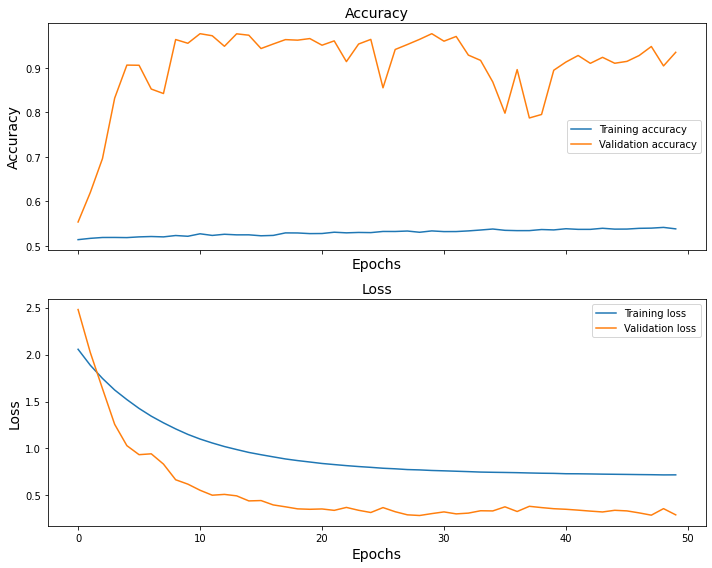

***********************************
model_2 : preprocessing1 without scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
___________

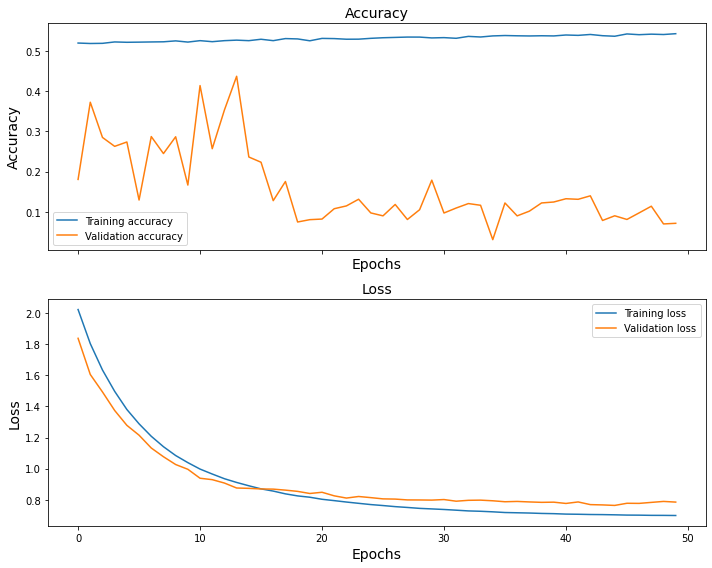

***********************************
model_3 : preprocessing2 with scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
______________

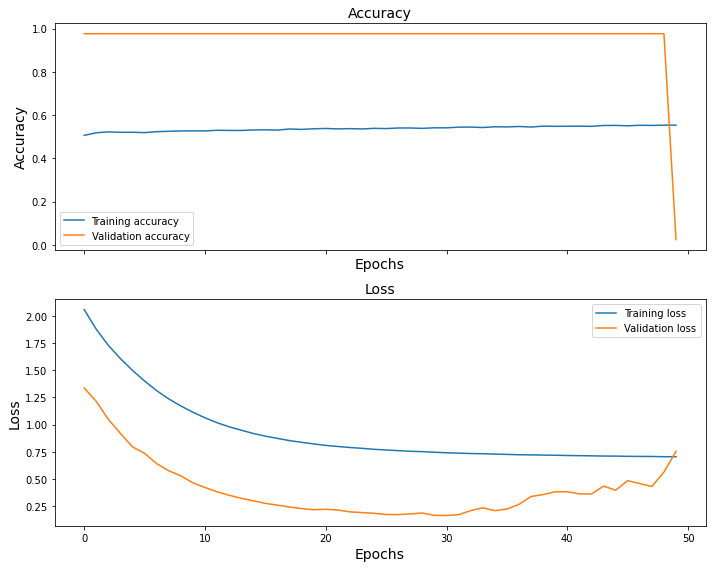

***********************************
model_4 : preprocessing2 without scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
___________

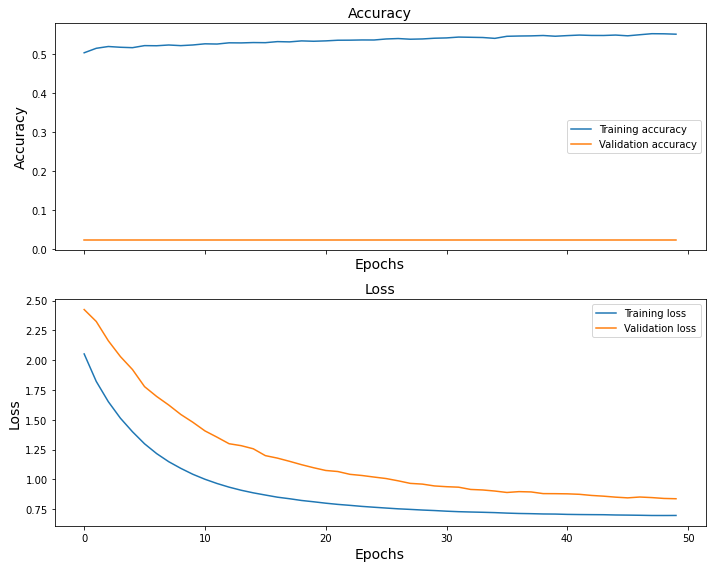

1e-06
***********************************
model_1 : preprocessing1 with scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
________

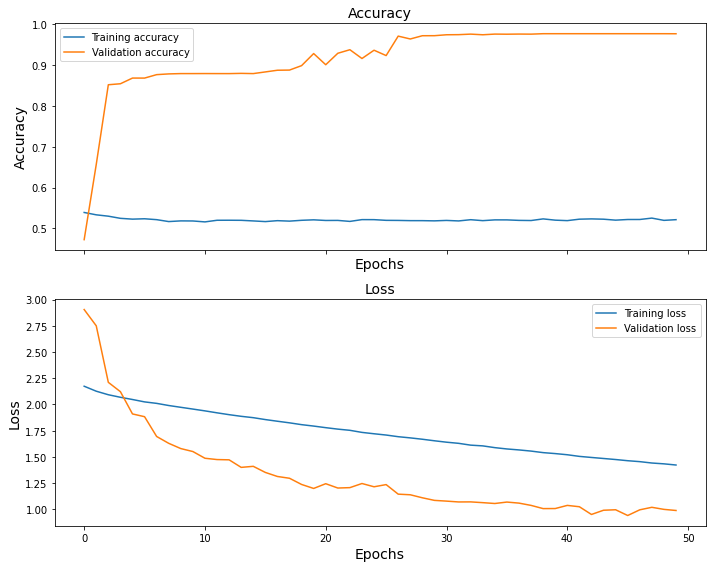

***********************************
model_2 : preprocessing1 without scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
___________

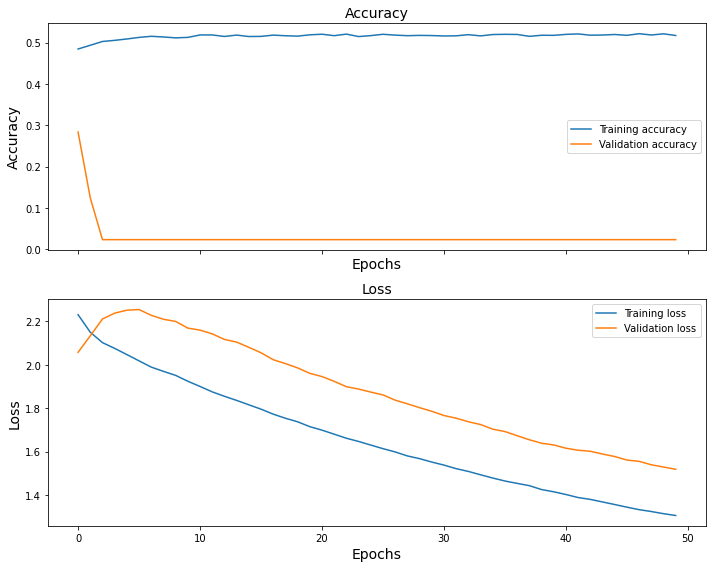

***********************************
model_3 : preprocessing2 with scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
______________

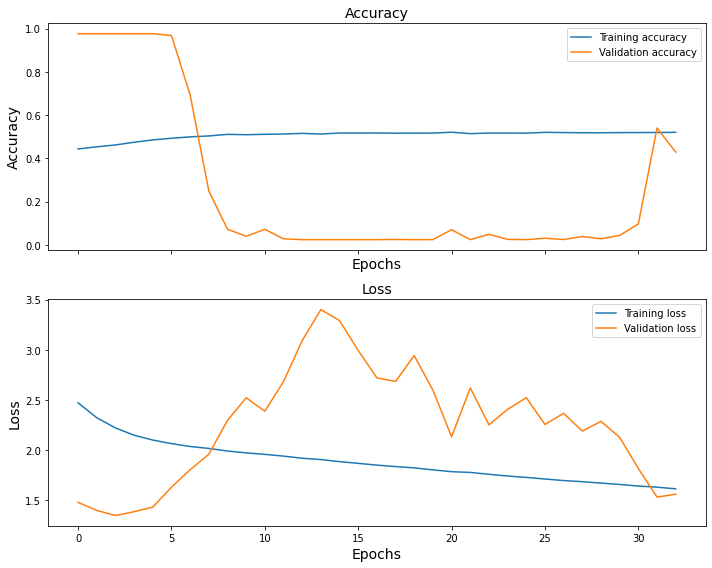

***********************************
model_4 : preprocessing2 without scale
***********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
___________

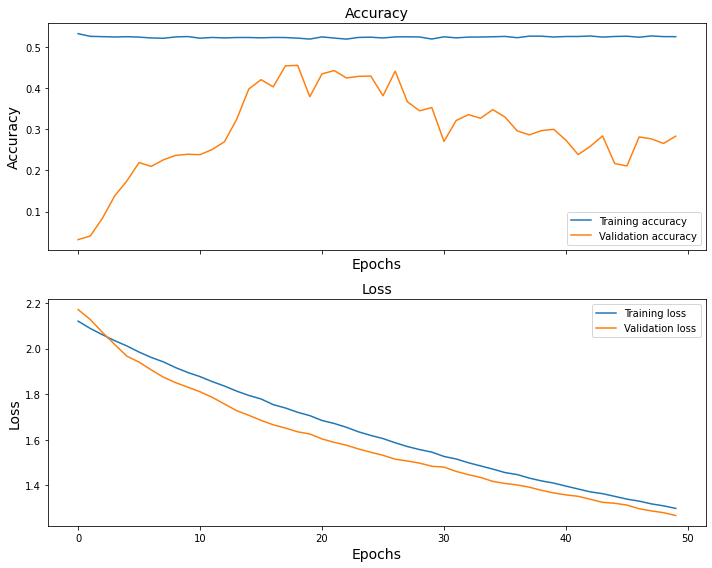

In [19]:
def runModels(tried_num,lr,X_train1,X_train2,X_train3,X_train4,Y_train,date, model_dir_path):
    print("***********************************")
    print("model_1 : preprocessing1 with scale")
    print("***********************************")
    model1 = create_model1(learning_rate,X_train1)

    history1=model1.fit(X_train1,
                      Y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.2,
                      callbacks=callback_list,
                      shuffle=True,
                      verbose=1)
    file_name = f'GRU_{date}_model_p1ws_lr={lr}_({tried_num})(2)'
    plt_performance(history1,path=f'./plot_performance/{date}',filename=file_name)
    model1.save(f"{model_dir_path}/{file_name}.h5")
    keras.backend.clear_session()
    
    print("***********************************")
    print("model_2 : preprocessing1 without scale")
    print("***********************************")
    model2 = create_model1(learning_rate,X_train2)

    history2=model2.fit(X_train2,
                      Y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.2,
                      callbacks=callback_list,
                      shuffle=True,
                      verbose=1)

    file_name = f'GRU_{date}_modelp1xs_lr={lr}_({tried_num})(2)'
    plt_performance(history2,path=f'./plot_performance/{date}',filename=file_name)
    model2.save(f"{model_dir_path}/{file_name}.h5")
    keras.backend.clear_session()
    
    
    print("***********************************")
    print("model_3 : preprocessing2 with scale")
    print("***********************************")
    model3 = create_model1(learning_rate,X_train3)

    history3=model3.fit(X_train3,
                      Y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.2,
                      callbacks=callback_list,
                      shuffle=True,
                      verbose=1)

    
    file_name = f'GRU_{date}_modelp2ws_lr={lr}_({tried_num})(2)'
    plt_performance(history3,path=f'./plot_performance/{date}',filename=file_name)
    model3.save(f"{model_dir_path}/{file_name}.h5")
    keras.backend.clear_session()

    
    print("***********************************")
    print("model_4 : preprocessing2 without scale")
    print("***********************************")
    model4 = create_model1(learning_rate,X_train4)

    history4=model4.fit(X_train4,
                      Y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.2,
                      callbacks=callback_list,
                      shuffle=True,
                      verbose=1)

    
    file_name = f'GRU_{date}_modelp2xs_lr={lr}_({tried_num})(2)'
    plt_performance(history4,path=f'./plot_performance/{date}',filename=file_name)
    model4.save(f"{model_dir_path}/{file_name}.h5")
    keras.backend.clear_session()
    
# Set Hyperparameters of the model
epochs = 50
batch_size=128
# learning_rate = 0.0000001
# learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
learning_rates = [0.00001, 0.000001]
learning_rate = 1e-05
index = 0
date = '0703'
for learning_rate in learning_rates:
    print(learning_rate)
    tried_num = index
    runModels(tried_num,learning_rate,X_train1,X_train2,X_train3,X_train4,Y_train,date,model_dir_path)
    index += 1
# runModels(index
#           ,learning_rate,X_train1,X_train2,X_train3,X_train4,Y_train,date,model_dir_path)